# Modelo para testar a hipótese "Períodos festivos, épocas do ano (estações do ano) e período de férias (julho, agosto, dezembro e janeiro) tem impacto sobre o número semanal de casos."

## Import das bibliotecas e dos dados

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

pd.set_option('display.max_columns', None)

path = os.path.abspath('../data/analise_crime_filtrado.csv')
df_guarda = pd.read_csv(path,comment='#', low_memory=False, parse_dates=['OCORRENCIA_DATA'])

path = os.path.abspath('../data/clima.csv')
df_clima = pd.read_csv(path,comment='#', low_memory=False)

df = pd.merge(df_guarda, df_clima, how='left')

df.head()

,OCORRENCIA_CODIGO,NATUREZA1_DESCRICAO,NATUREZA,ATENDIMENTO_BAIRRO_NOME,REGIONAL_FATO_NOME,OCORRENCIA_ANO,OCORRENCIA_DATA,OCORRENCIA_HORA,OCORRENCIA_HORA_SEM_MINUTO,OCORRENCIA_MES,OCORRENCIA_DIA_SEMANA,OCORRENCIA_DATA_SEM_HORARIO,FERIADO,LATITUDE,LONGITUDE,T_MEDIA,T_MINIMA,T_MAXIMA,CHUVA
0,5122.0,Roubo,ROUBO,XAXIM,BOQUEIRÃO,2009.0,2009-03-13 09:20:00,09:20:00,9,3.0,SEXTA,2009-03-13,0.0,-25.426683,-49.272357,19.8,17.1,23.8,137
1,5507.0,Atos obscenos/libidinosos,PUDOR,BAIRRO ALTO,BOA VISTA,2009.0,2009-03-19 12:05:00,12:05:00,12,3.0,QUINTA,2009-03-19,0.0,-25.412337,-49.205083,19.8,17.1,23.8,137
2,4899.0,Embriaguez,RISCO_VIDA,FAZENDINHA,PORTÃO,2009.0,2009-03-09 14:00:00,14:00:00,14,3.0,SEGUNDA,2009-03-09,0.0,NaN,NaN,19.8,17.1,23.8,137
3,5401.0,Furto,ROUBO,FAZENDINHA,PORTÃO,2009.0,2009-03-16 20:11:00,20:11:00,20,3.0,SEGUNDA,2009-03-16,0.0,NaN,NaN,19.8,17.1,23.8,137
4,3084.0,Ameaça,AGRESSAO,BOA VISTA,BOA VISTA,2009.0,2009-02-13 08:10:00,08:10:00,8,2.0,SEXTA,2009-02-13,0.0,-25.393377,-49.259794,20.6,17.8,24.7,199


## Agrupando e filtrando dados de interesse

In [140]:
df2 = df.groupby(['OCORRENCIA_DATA_SEM_HORARIO'])['OCORRENCIA_DATA_SEM_HORARIO'].count().reset_index(name = 'CASOS')

df3 = df.groupby(['OCORRENCIA_DATA_SEM_HORARIO']).mean().reset_index()[['OCORRENCIA_ANO', 'OCORRENCIA_MES', 'OCORRENCIA_DATA_SEM_HORARIO', 'FERIADO', 'T_MEDIA', 'CHUVA']]

df4 = df.groupby(['OCORRENCIA_DATA_SEM_HORARIO']).max().reset_index()[['OCORRENCIA_DATA_SEM_HORARIO','OCORRENCIA_DIA_SEMANA']]

df3 = pd.merge(df2, df3, how='left')

df3 = pd.merge(df3, df4, how='left')

df3 = df3.astype({'OCORRENCIA_ANO': int, 'OCORRENCIA_MES': int, 'FERIADO': int, 'CHUVA': int}).set_index('OCORRENCIA_DATA_SEM_HORARIO')

df2 = df3[['CASOS', 'FERIADO', 'T_MEDIA', 'CHUVA', 'OCORRENCIA_DIA_SEMANA']]

df2.index.names = ['DATA']

df2 = df2.query("DATA > '2020-01-01' and DATA < '2021-01-01'")

df2.head()

,CASOS,FERIADO,T_MEDIA,CHUVA,OCORRENCIA_DIA_SEMANA
DATA,,,,,
2020-01-02,6,0,20.4,233,QUINTA
2020-01-03,19,0,20.4,233,SEXTA
2020-01-04,7,0,20.4,233,SÁBADO
2020-01-05,18,0,20.4,233,DOMINGO
2020-01-06,10,0,20.4,233,SEGUNDA


## Analises iniciais

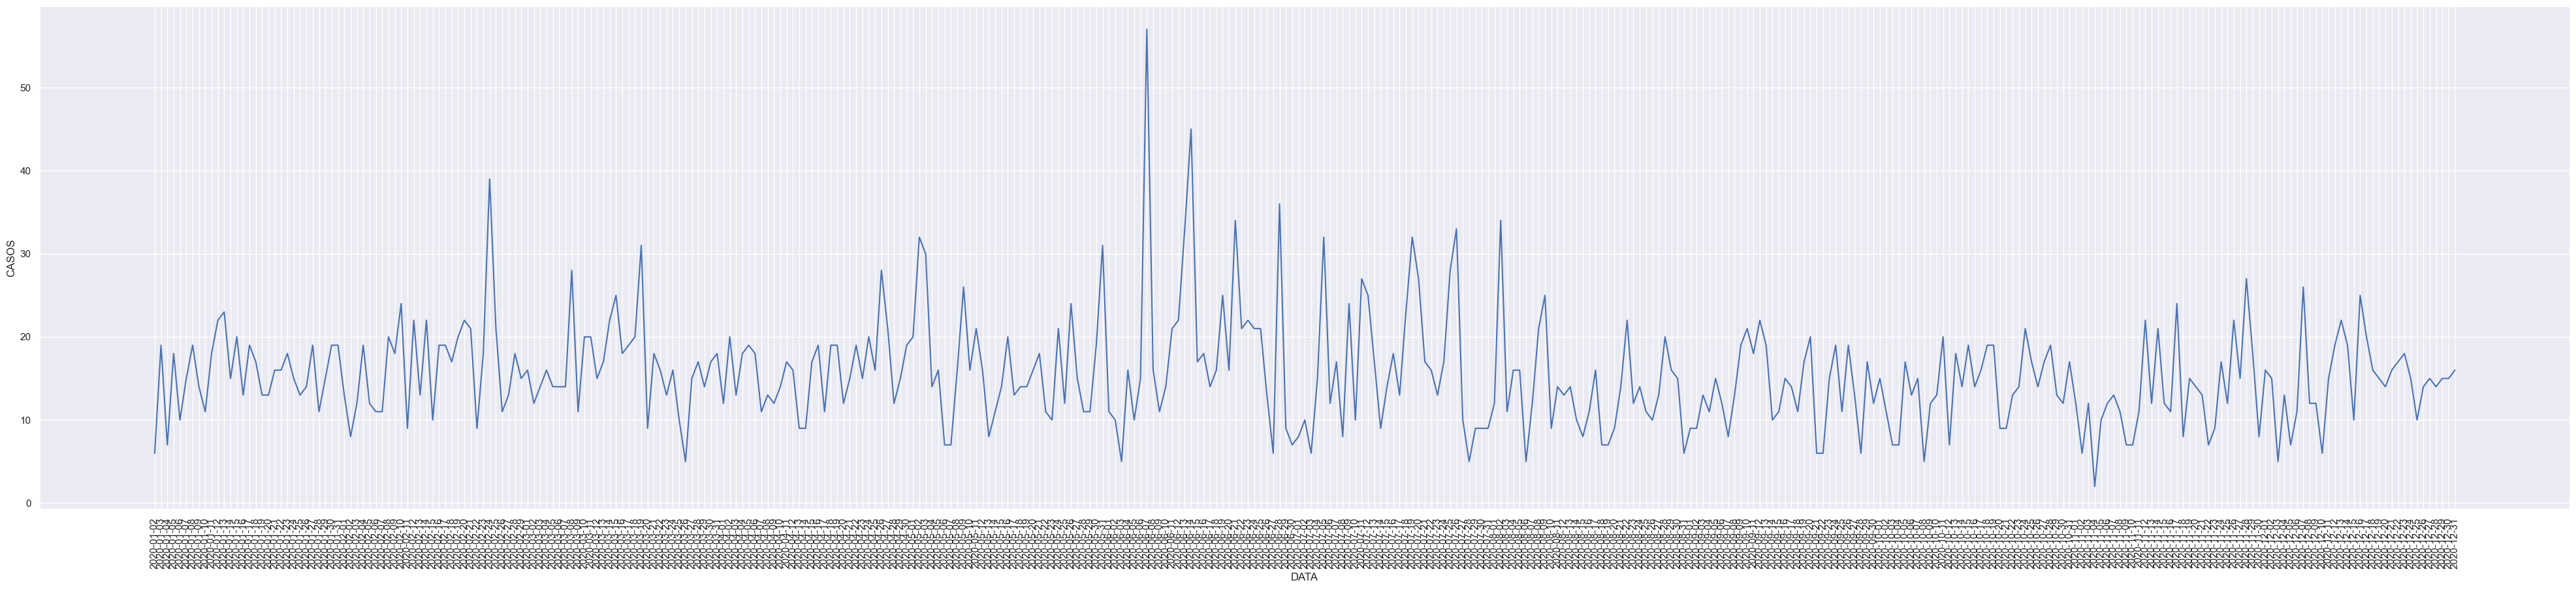

In [141]:
plt.rcParams.update({'figure.figsize': (50,10)})
sns.lineplot(x="DATA", y="CASOS",  data=df2)

plt.xticks(rotation=90)
plt.show()

C:\Users\jfsma\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


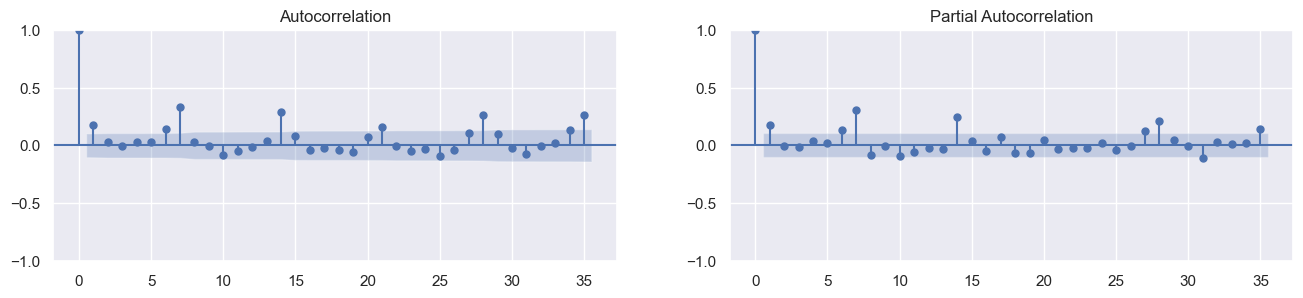

In [142]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df2.CASOS.tolist(), lags=35, ax=axes[0])
plot_pacf(df2.CASOS.tolist(), lags=35, ax=axes[1])

plt.show()

## Analisando a tendência

In [143]:
df2['CASOS_ROLLING_AVG'] = df2['CASOS'].rolling(7, center=True).mean()

df2.head(10)

,CASOS,FERIADO,T_MEDIA,CHUVA,OCORRENCIA_DIA_SEMANA,CASOS_ROLLING_AVG
DATA,,,,,,
2020-01-02,6,0,20.4,233,QUINTA,NaN
2020-01-03,19,0,20.4,233,SEXTA,NaN
2020-01-04,7,0,20.4,233,SÁBADO,NaN
2020-01-05,18,0,20.4,233,DOMINGO,13.428571
2020-01-06,10,0,20.4,233,SEGUNDA,14.571429
2020-01-07,15,0,20.4,233,TERÇA,13.428571
2020-01-08,19,0,20.4,233,QUARTA,15.000000
2020-01-09,14,0,20.4,233,QUINTA,15.571429
2020-01-10,11,0,20.4,233,SEXTA,17.428571


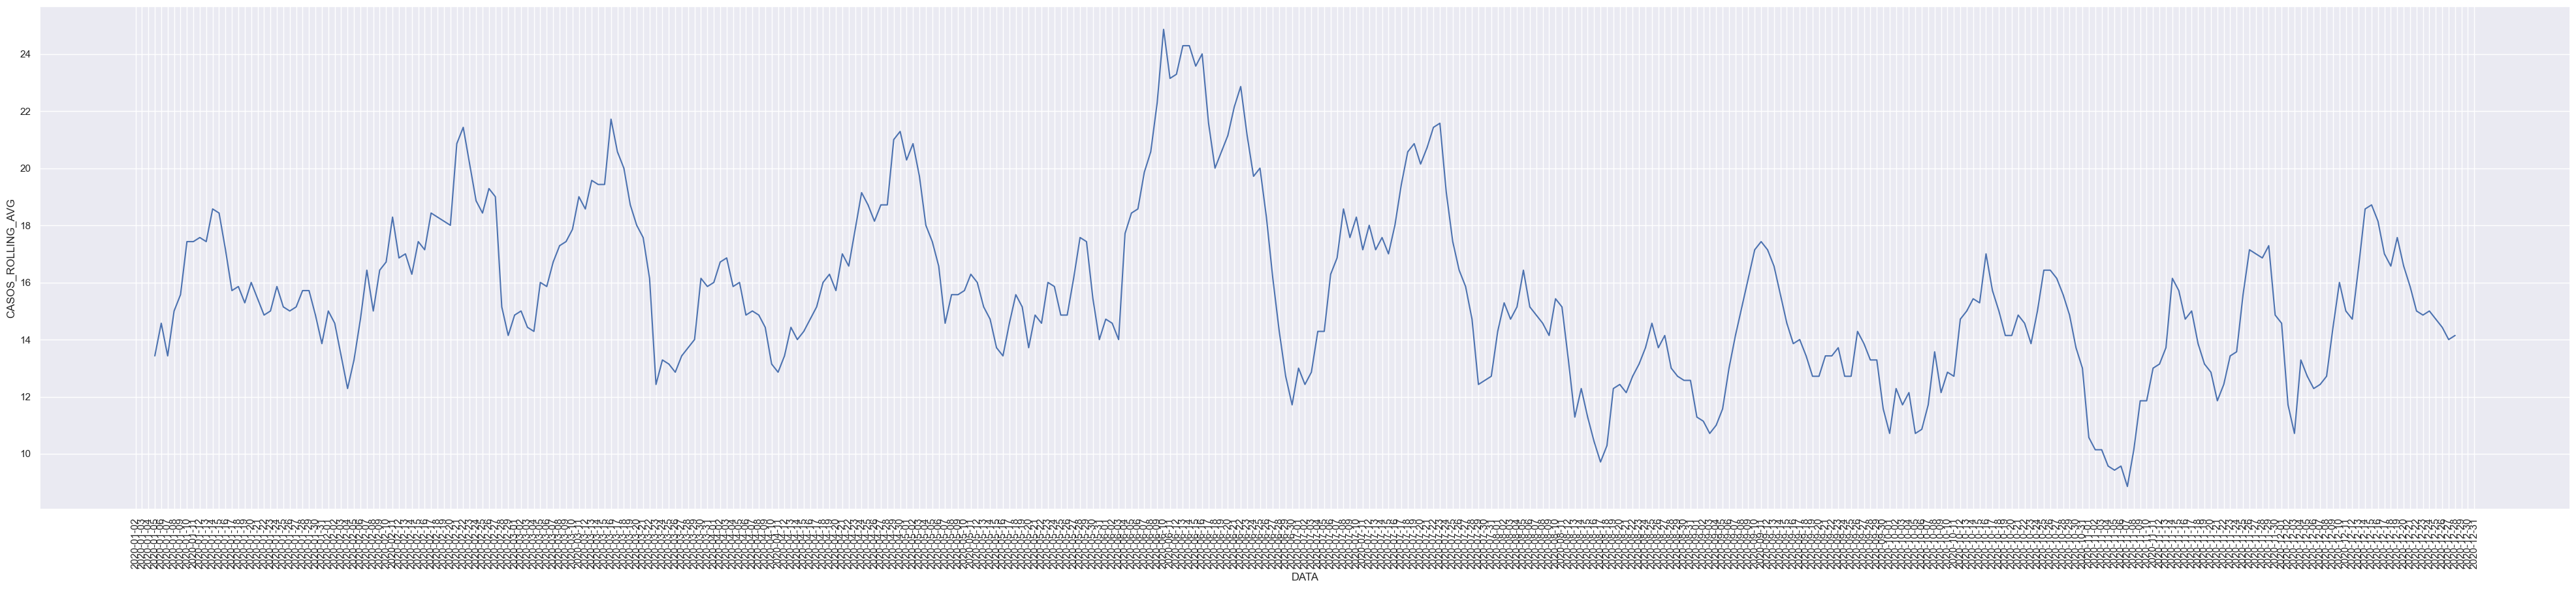

In [144]:
sns.lineplot(x="DATA", y="CASOS_ROLLING_AVG",  data=df2)
plt.xticks(rotation=90)
plt.show()

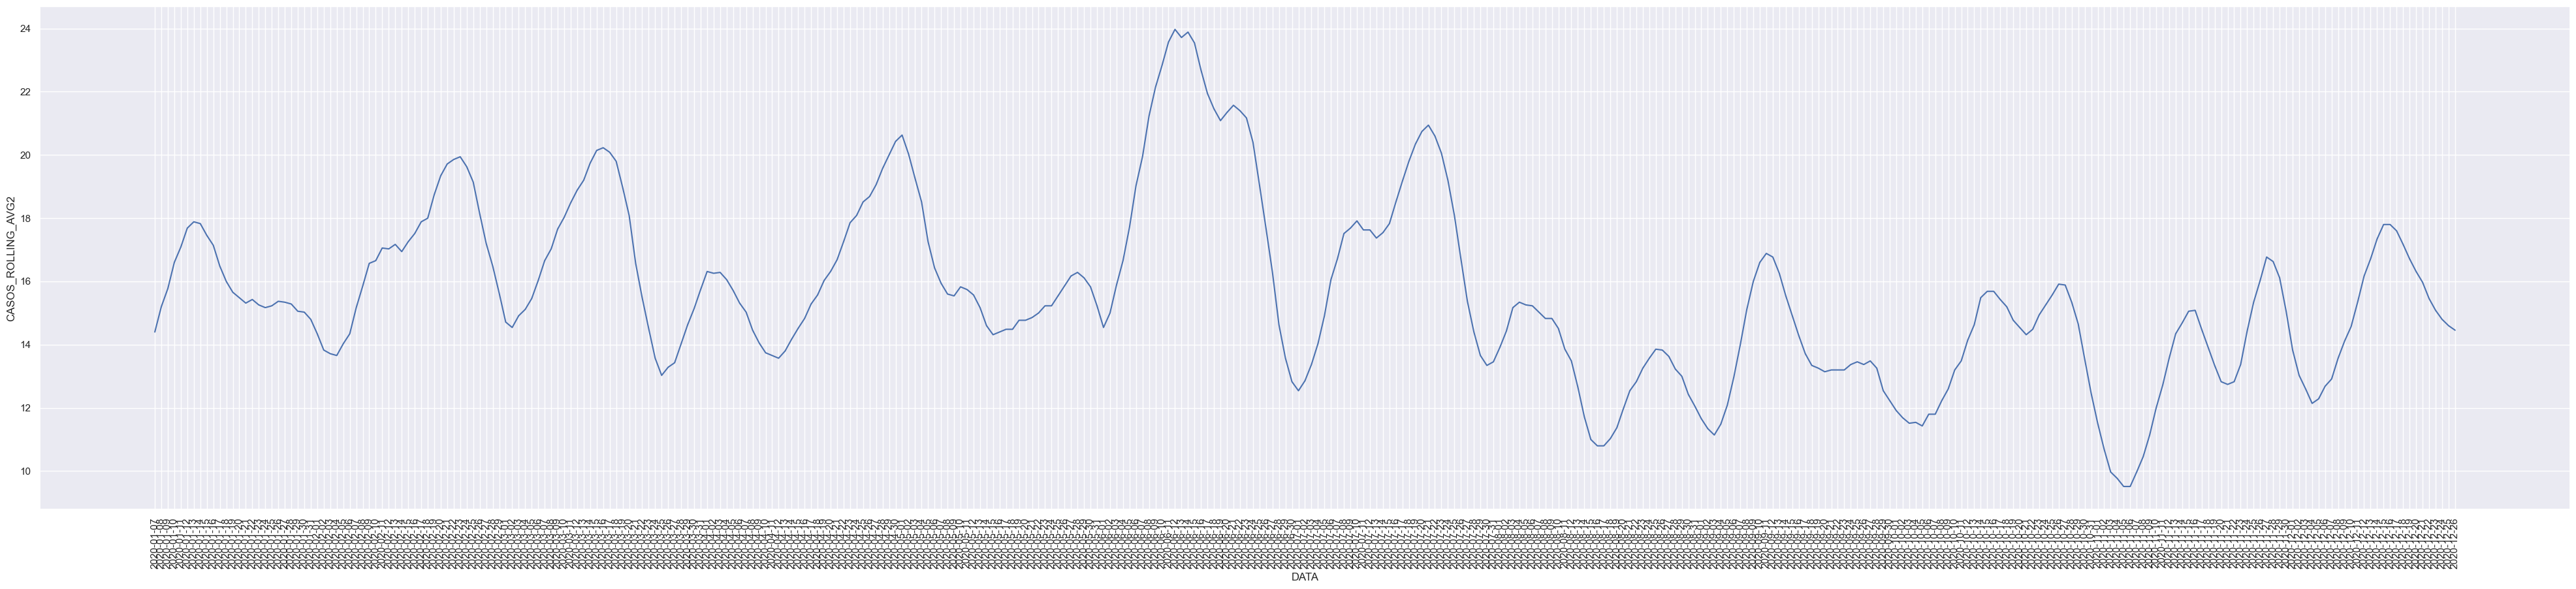

In [145]:
df2['CASOS_ROLLING_AVG2'] = df2['CASOS_ROLLING_AVG'].rolling(5, center=True).mean()

df2 = df2.dropna(how='any')

sns.lineplot(x="DATA", y="CASOS_ROLLING_AVG2",  data=df2)
plt.xticks(rotation=90)
plt.show()

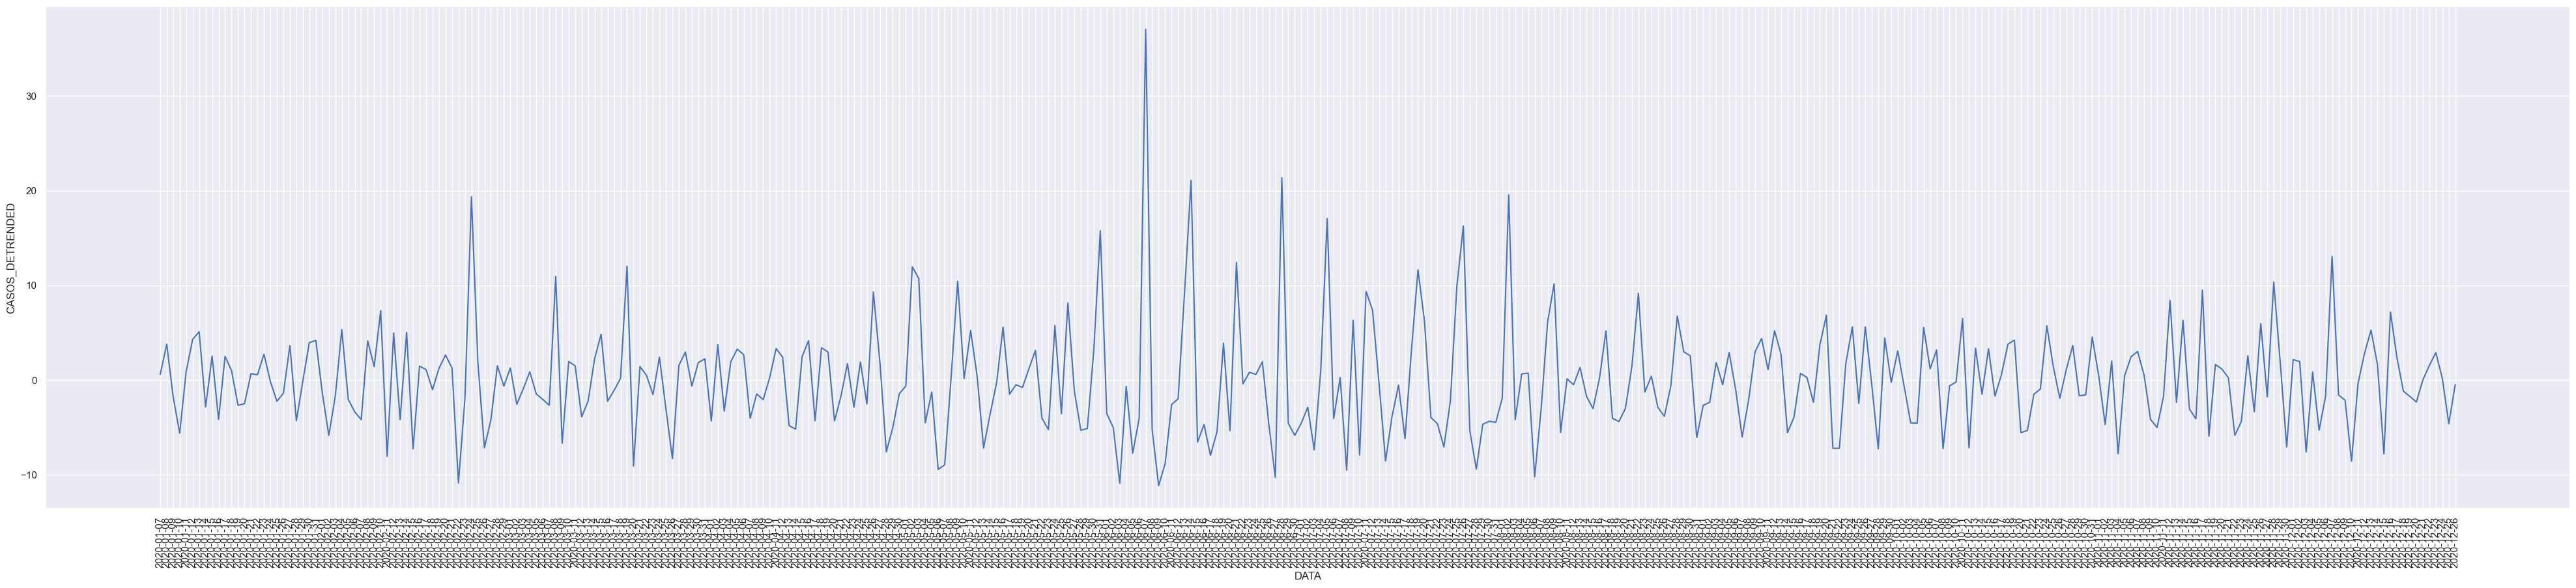

In [146]:
df2['CASOS_TREND'] = df2['CASOS_ROLLING_AVG2']

df2['CASOS_DETRENDED'] = df2['CASOS'] - df2['CASOS_TREND']

sns.lineplot(x="DATA", y="CASOS_DETRENDED",  data=df2)
plt.xticks(rotation=90)
plt.show()

## Analisando a sazonalidade

<AxesSubplot:xlabel='OCORRENCIA_DIA_SEMANA', ylabel='CASOS'>

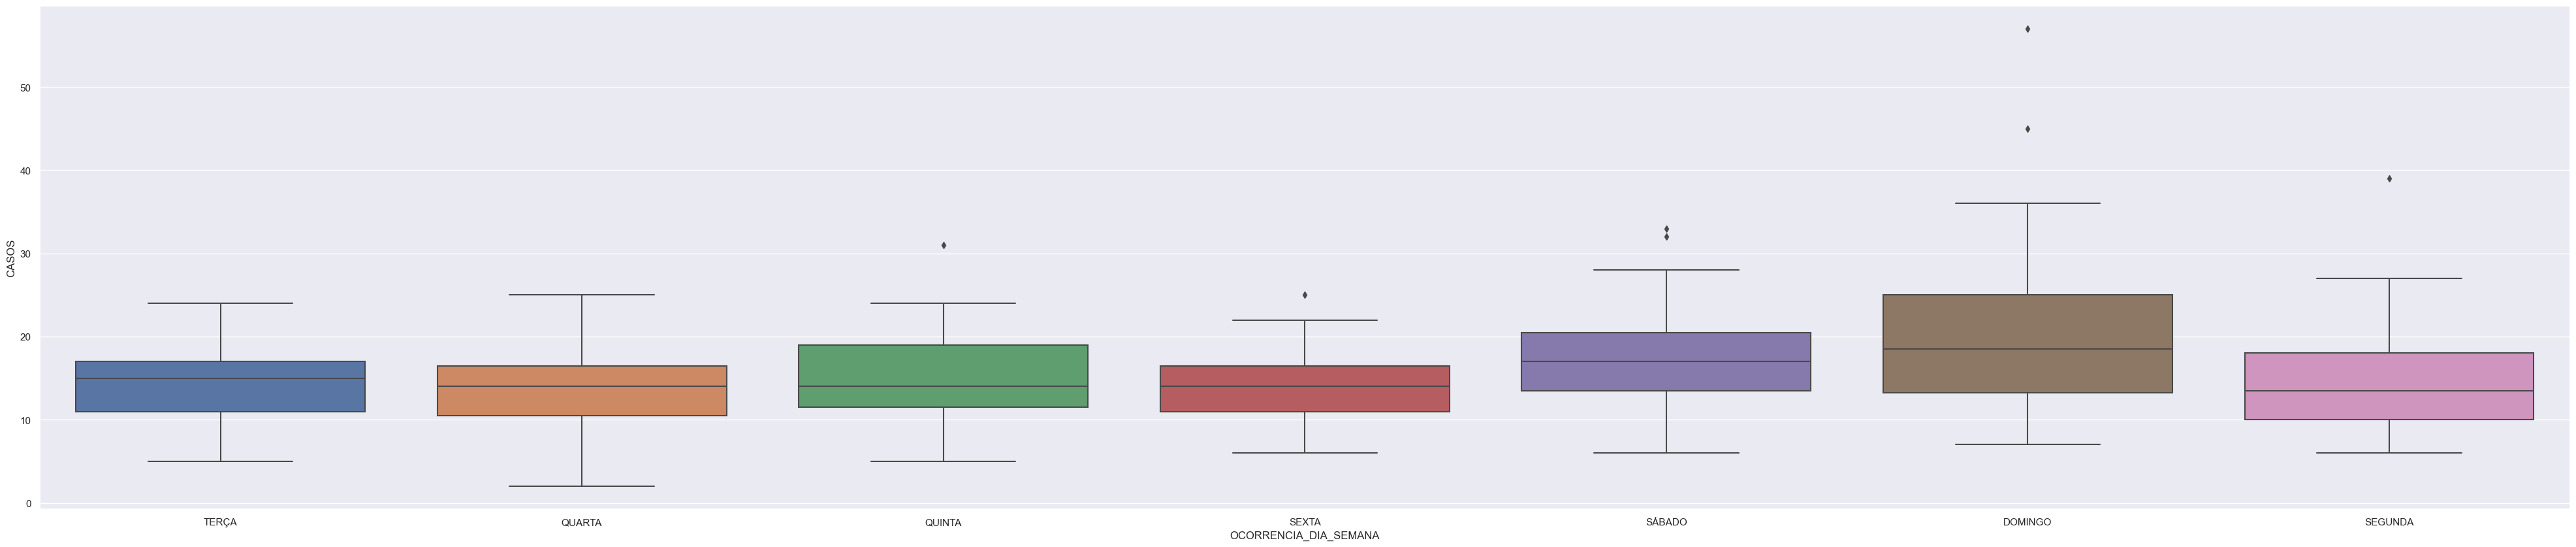

In [147]:
sns.boxplot(x='OCORRENCIA_DIA_SEMANA', y='CASOS', data=df2)

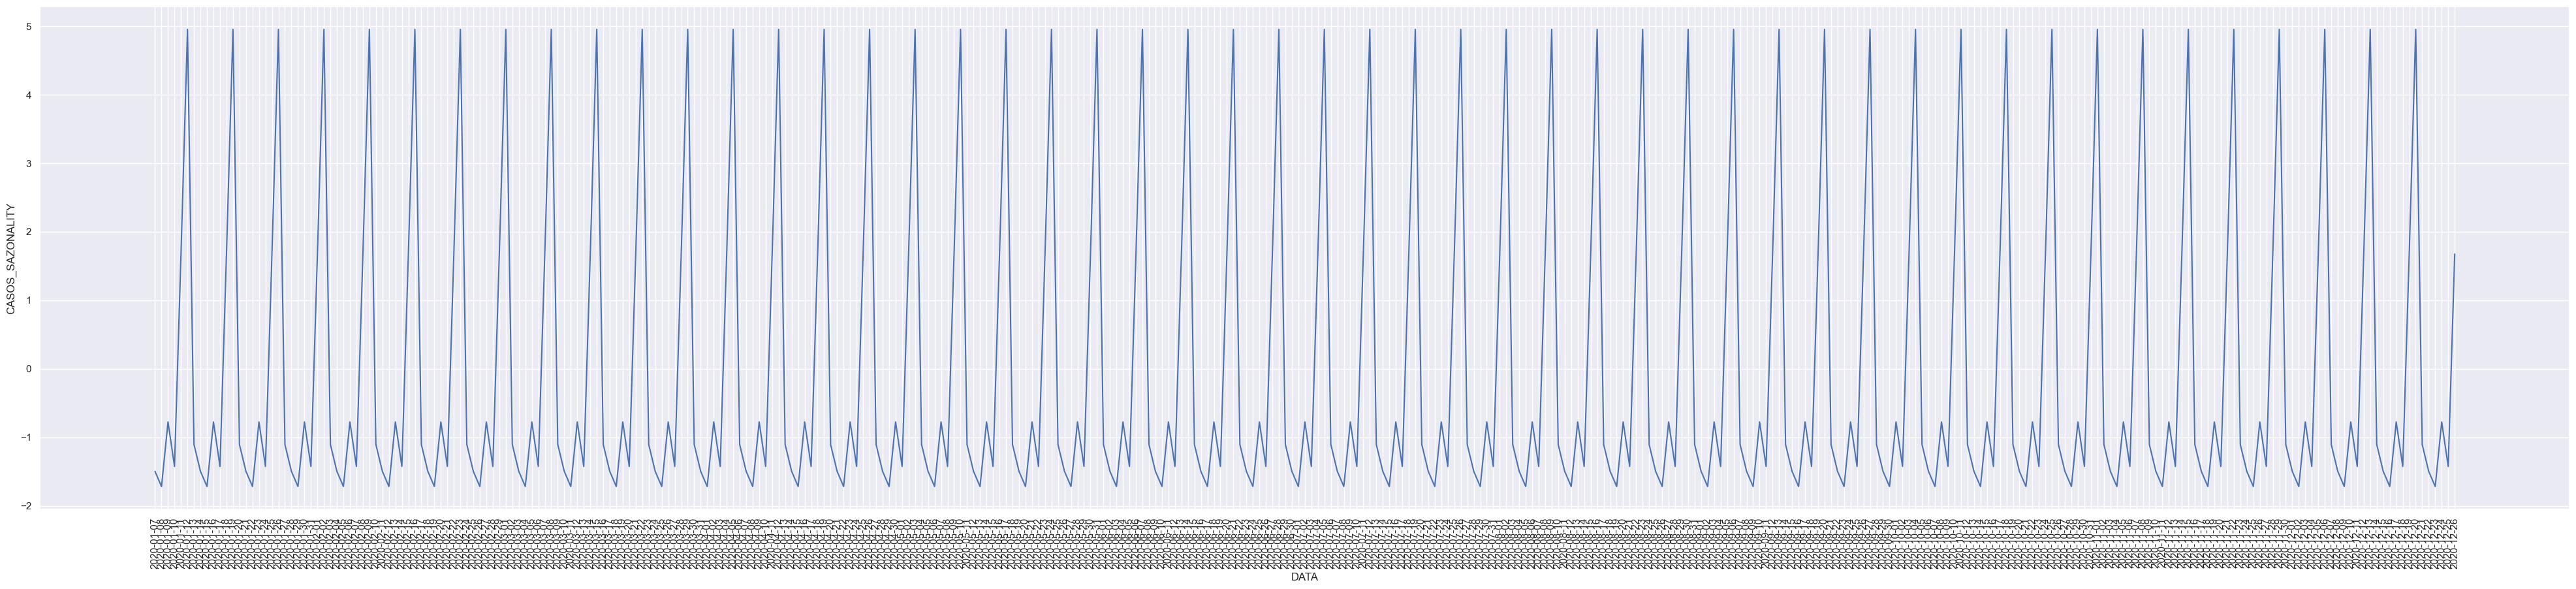

In [148]:
df2['CASOS_SAZONALITY'] = df2.groupby('OCORRENCIA_DIA_SEMANA')['CASOS_DETRENDED'].transform('mean')

sns.lineplot(x="DATA", y="CASOS_SAZONALITY",  data=df2)
plt.xticks(rotation=90)
plt.show()

## Resíduo

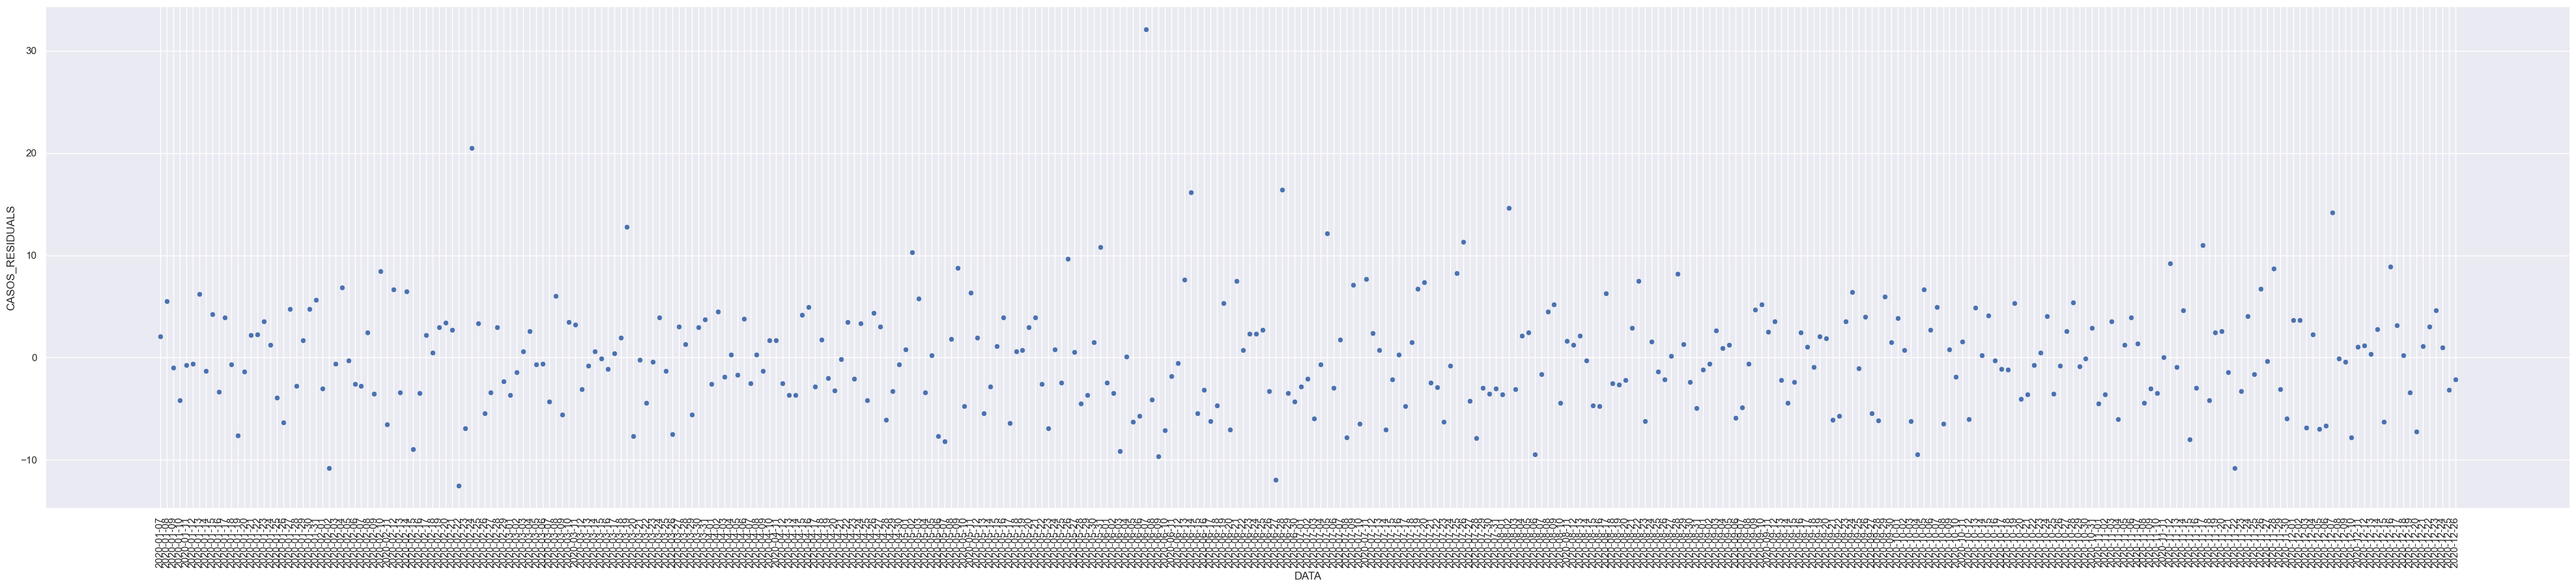

In [149]:
df2['CASOS_RESIDUALS'] = df2['CASOS'] - df2['CASOS_TREND'] - df2['CASOS_SAZONALITY']

sns.scatterplot(x="DATA", y="CASOS_RESIDUALS",  data=df2)
plt.xticks(rotation=90)
plt.show()

## Decomposição de Séries usando Statsmodels

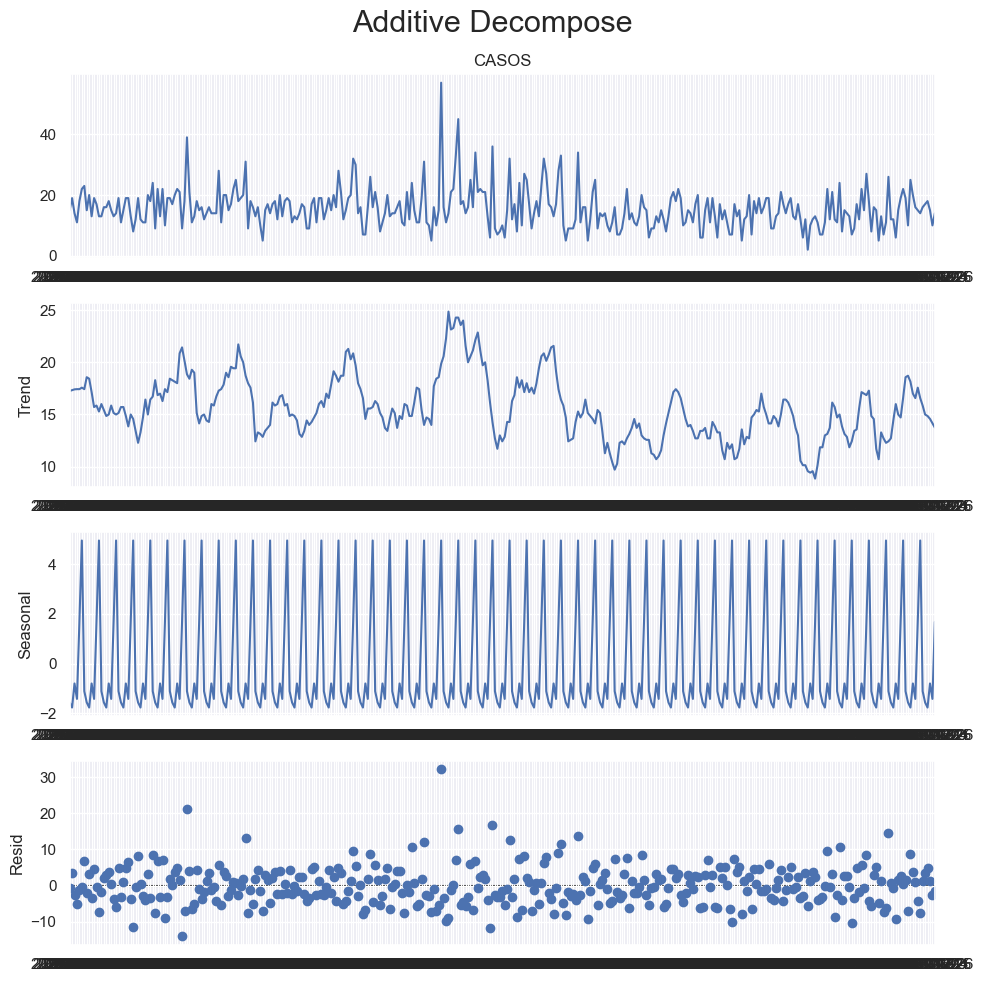

In [150]:
df2 = df2.dropna(how='any')

df2.sort_index(inplace=True)

# Additive Decomposition
result_add = seasonal_decompose(df2['CASOS'], model='additive', extrapolate_trend='freq', period=7)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})

result_add.plot().suptitle('Additive Decompose', fontsize=22)

plt.tight_layout()
plt.show()

## Série estacionária

In [151]:
#Run ADF test
adf_result = adfuller(df2['CASOS'], autolag='AIC')
print('p-val of the ADF test on covid_cases:', adf_result[1])

adf_result = adfuller(df2['CASOS_DETRENDED'], autolag='AIC')
print('p-val of the ADF test on cases_detrended:', adf_result[1])

p-val of the ADF test on covid_cases: 0.007927245430433202
p-val of the ADF test on cases_detrended: 2.3266462146809457e-16


C:\Users\jfsma\AppData\Local\Temp\ipykernel_15700\3566324123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['CASOS_DIFF'] = df2['CASOS'].diff(1)


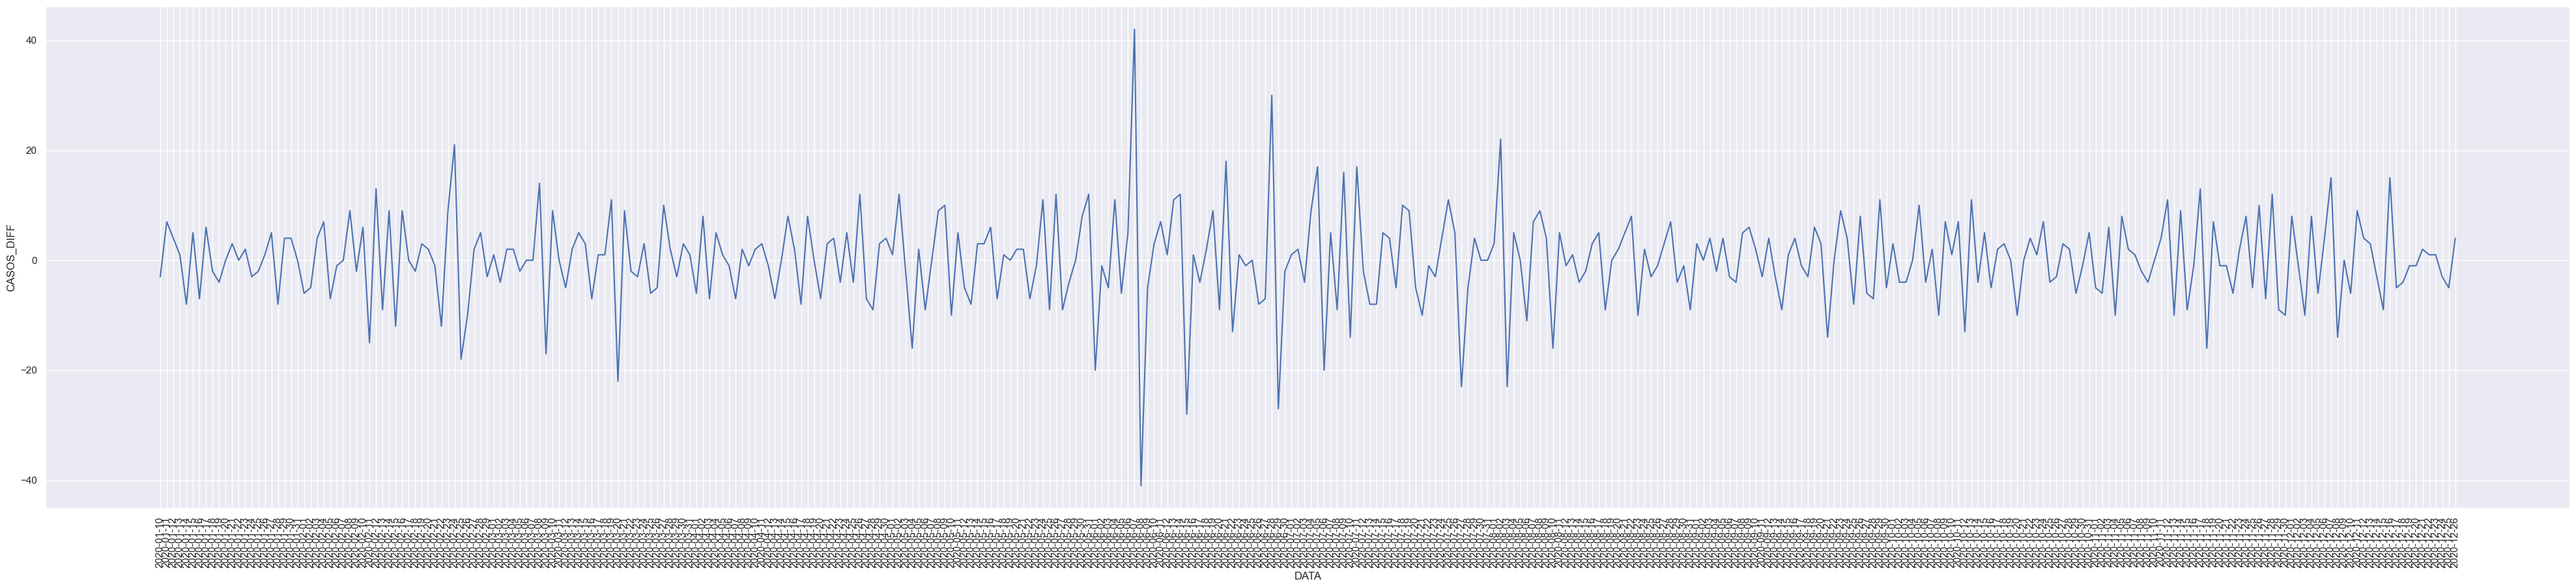

In [154]:
df2['CASOS_DIFF'] = df2['CASOS'].diff(1)

df2 = df2.dropna(how='any')
plt.rcParams.update({'figure.figsize': (50,10)})
sns.lineplot(x="DATA", y="CASOS_DIFF",  data=df2)
plt.xticks(rotation=90)
plt.show()

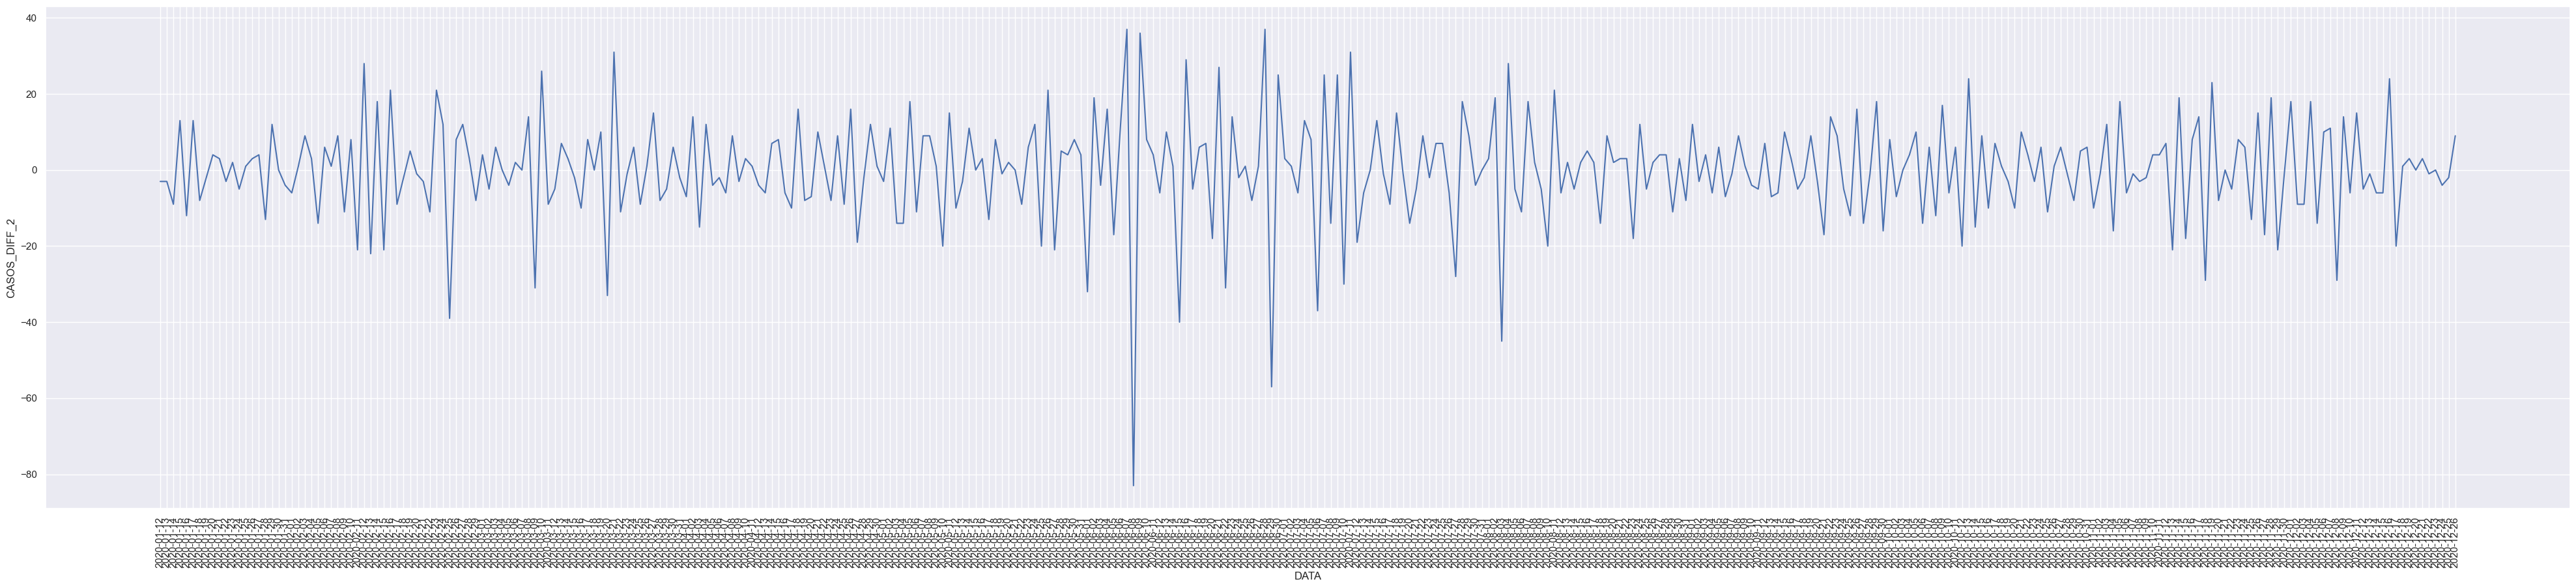

In [155]:
df2['CASOS_DIFF_2'] = df2['CASOS'].diff(1).diff(1)

df2 = df2.dropna(how='any')
plt.rcParams.update({'figure.figsize': (50,10)})
sns.lineplot(x="DATA", y="CASOS_DIFF_2",  data=df2)
plt.xticks(rotation=90)
plt.show()

In [157]:
#Run ADF test
adf_result = adfuller(df2['CASOS_DIFF'], autolag='AIC')
print('p-val of the ADF test on covid_cases_diff:', adf_result[1])

adf_result = adfuller(df2['CASOS_DIFF_2'], autolag='AIC')
print('p-val of the ADF test on covid_cases_diff_2nd:', adf_result[1])

p-val of the ADF test on covid_cases_diff: 6.15173543809882e-15
p-val of the ADF test on covid_cases_diff_2nd: 1.1339951598266324e-17
